In [1]:
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, find_nearest_ind, get_evoked_firing_rates
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

#### Functions

In [6]:
# get event triggered firing rates USING find_nearest_ind
def get_evoked_traces(data, timestamps, events, plot_before, plot_after, data_sample_rate):
    pre_inds = int(plot_before * data_sample_rate)
    post_inds = int(plot_after * data_sample_rate)
    timex = (np.arange(-pre_inds, post_inds) / data_sample_rate)
    
    evoked_traces = np.zeros((len(timex), np.shape(data)[1], len(events)))
    for j, jtime in enumerate(events):
        zeroind = find_nearest_ind(timestamps, jtime)
        data_inds = np.arange(zeroind-pre_inds, zeroind+post_inds)
        evoked_traces[:,:,j] = data[data_inds,:]
    
    return evoked_traces, timex

In [7]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

In [8]:
def lowpass_filt_design(len_signal, sample_rate, cutoff_freq=200, trans_width=0.2, order_multiple=11, plot_kern=False):
    hz = np.linspace(0, sample_rate/2, int(np.floor(len_signal/2)+1))

    ## determine order
    order = np.round(order_multiple * sample_rate / cutoff_freq) + 1
    if order%2 == 0:
        order += 1 # order must be odd for signal.firls

    shape = [1,1,0,0]
    frex = [0, cutoff_freq, cutoff_freq*(1+trans_width), sample_rate/2]

    # filter kernel
    filtkern = signal.firls(order, frex, shape, fs=sample_rate)

    if plot_kern:
        # its power spectrum
        filtkernX = np.abs(fftpack.fft(filtkern, len_signal))**2

        fig, axs = plt.subplots(1, 2)
        axs[0].plot(np.arange(-order/2, order/2)/sample_rate, filtkern, 'k')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_title('Filter kernel')

        axs[1].plot(np.array(frex), shape, 'r')
        axs[1].plot(hz, filtkernX[:len(hz)], 'k')
        axs[1].set_xlim([0, cutoff_freq*(1+trans_width) + 50])
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('Gain')
        axs[1].set_title('Filter kernel spectrum')
        plt.show()
    
    return filtkern

#### All subjects, bad channels

In [9]:
multisub_bad_chs = {
    '521885': [6,11,12,13,14],
    '521886': [11,12,13,14,15,16,17], # was [10,11,12,13,14,15,16,17,18]
    '521887': [4,11,12,13,14], # was [4,7,11,12,13,14,18]
    '543393': [11,12,13,14],
    '543394': [11,12,13,14,15,17,18,19,20],
    '543395': [11,12,13], # was [11,13]
    '543396': [4,5,7,8,10,11,12,13], # [4,5,7,8,10,11,12,13,14]
    '546655': [],
    '547868': [],
}

### Define data path

In [10]:
rec_folder = r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse547868\estim_vis_2020-12-04_11-24-26\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


In [11]:
bad_chs = multisub_bad_chs[exp.mouse]

In [12]:
mouse_folder = exp.mouse
# Make a folder in my OneDrive to save plots
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + mouse_folder)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)
    print(plotsavedir)

#### Load stim table

In [13]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep
0,biphasic,20,31.93587,31.93627,0.0004,0
1,biphasic,20,35.80521,35.80561,0.0004,0
2,biphasic,40,39.76635,39.76675,0.0004,0
3,biphasic,60,44.24842,44.24882,0.0004,0
4,biphasic,60,47.90523,47.90563,0.0004,0


In [14]:
stim_log[916:925]

,stim_type,parameter,onset,offset,duration,sweep
916,fullscreen,white,4166.23646,4166.50475,0.26829,1
917,fullscreen,white,4170.57342,4170.84171,0.26829,1
918,fullscreen,white,4174.89371,4175.16200,0.26829,1
919,fullscreen,white,4179.06386,4179.33215,0.26829,1
920,biphasic,20,4204.39609,4204.39649,0.00040,2
921,biphasic,20,4208.26544,4208.26584,0.00040,2
922,biphasic,40,4212.22658,4212.22698,0.00040,2
923,biphasic,60,4216.70865,4216.70905,0.00040,2
924,biphasic,60,4220.36548,4220.36588,0.00040,2


In [15]:
stim_log.tail()

,stim_type,parameter,onset,offset,duration,sweep
1275,biphasic,60,5625.20608,5625.20648,0.0004,2
1276,biphasic,60,5628.88463,5628.88503,0.0004,2
1277,biphasic,60,5632.74469,5632.74509,0.0004,2
1278,biphasic,20,5636.30181,5636.30221,0.0004,2
1279,biphasic,60,5640.32412,5640.32452,0.0004,2


#### Load EEG data

In [16]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])

In [17]:
print(eeg_ts[0:10])

[19.57916795 19.57956795 19.57996796 19.58036796 19.58076797 19.58116797
 19.58156797 19.58196798 19.58236798 19.58276799]


In [18]:
print(eeg_ts[-1])

5705.331338568107


### Get spectra of certain time points

In [20]:
## 547868, urethane ##
spectra_times = [20., 3710., 5671.]
labels = ['awake', 'early urethane', 'late urethane']
spcol = ['navy', 'darkviolet', 'violet']
time_win = 10 # s
cha = 7

spectra = {}
for ii, timei in enumerate(spectra_times):
    timeinds = np.squeeze(np.argwhere((eeg_ts > timei) & (eeg_ts < timei+time_win)))
    eeg_traces = eeg_data[timeinds, :]
#     eeg_xaxis = eeg_ts[plot_inds]
    frex, Pxx = signal.welch(eeg_traces[:, cha], exp.ephys_params['EEG']['sample_rate'], nperseg=exp.ephys_params['EEG']['sample_rate'], axis=0)
    spectra[labels[ii]] = Pxx

In [21]:
frinds = frex < 100
print(len(frex))
print(np.sum(frinds))

1251
100


<IPython.core.display.Javascript object>


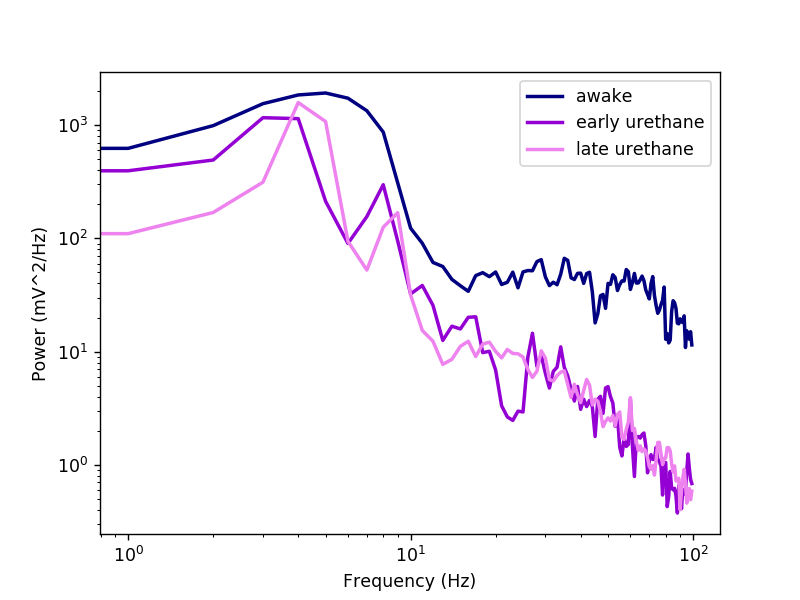

In [23]:
fig, ax = plt.subplots()
    
for ii, (labeli, Pxxi) in enumerate(spectra.items()):
    ax.loglog(frex[frinds], Pxxi[frinds], color=spcol[ii], linewidth=2)
#     ax.plot(frex[frinds], Pxxi[frinds], color=spcol[ii], linewidth=2)

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.legend(labels)

### SAVE ###
# fig.savefig(os.path.join(plotsavedir, 'spectral_analysis.png'), transparent=True)